In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/jenny_train_256_256_gamma_1.3_1.5/hr'
lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/jenny_train_256_256_gamma_1.3_1.5/ir'
# hiseq_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/jenny_train_256_256_gamma_1.3_1.5/hiseq'

hr_files = [p for p in Path('{}'.format(hr_path)).glob(f'**/*')]
hr_files=sorted(hr_files, key=lambda i: int(i.stem))

lr_files = [p for p in Path('{}'.format(lr_path)).glob(f'**/*')]
lr_files=sorted(lr_files, key=lambda i: int(i.stem))

# hiseq_files = [p for p in Path('{}'.format(hiseq_path)).glob(f'**/*')]
# hiseq_files=sorted(hiseq_files, key=lambda i: int(i.stem))

In [2]:
mean_hr = [0.39252543449401855, 0.40171757340431213, 0.38263097405433655]
std_hr = [0.20434394478797913, 0.22033677995204926, 0.22062578797340393]

mean_lr = [0.44012442231178284, 0.44012442231178284, 0.44012442231178284]
std_lr = [0.09716984629631042, 0.09716984629631042, 0.09716984629631042]

# mean_lr = [0.5, 0.5, 0.5]
# std_lr = [0.5, 0.5, 0.5]

# mean_hiseq = [0, 0, 0]
# std_hiseq = [1, 1, 1]

transform_hr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hr, std_hr)
])

transform_lr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_lr, std_lr)
])

# transform_hiseq = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean_hiseq, std_hiseq)
# ])

In [3]:
def to_tensor_and_normalize(files, mode='LR'):
    img_ls = []

    for file in tqdm(files):
        img = Image.open(file).convert('RGB')
        if mode == 'HR':
            img = transform_hr(img)
        elif mode == 'LR':
            img = transform_lr(img)
        else:
            img = transform_hiseq(img)
        img_ls.append(img)
    
    img_ls = torch.stack(img_ls, 0)

    return img_ls

In [4]:
hr_imgs = to_tensor_and_normalize(hr_files, 'HR')
lr_imgs = to_tensor_and_normalize(lr_files, 'LR')
# hiseq_imgs = to_tensor_and_normalize(hiseq_files, 'Hiseq')

100%|██████████| 967/967 [00:03<00:00, 293.94it/s]


In [5]:
def find_y_avg(imgs):
    y_list = []
    
    for i in tqdm(range(imgs.shape[0])):
        y = 0.299*imgs[i,0,:,:] + 0.587*imgs[i,1,:,:] + 0.114*imgs[i,2,:,:]
        y_avg = np.average(y)
        y_list.append(y_avg)
    
    return np.array(y_list)

In [6]:
def calculate_mean_std(imgs):

    mean_ls = []
    std_ls = []
    
    channels = imgs.shape[1]

    for i in tqdm(range(channels)):
        all_pixels = imgs[:,i,:,:]
        
        std, mean = torch.std_mean(all_pixels)

        mean_ls.append(mean.item())
        std_ls.append(std.item())
    
    return mean_ls, std_ls
    

In [7]:
mean_hr, std_hr = calculate_mean_std(hr_imgs)
print(mean_hr)
print(std_hr)

mean_lr, std_lr = calculate_mean_std(lr_imgs)
print(mean_lr)
print(std_lr)

# mean_hiseq, std_hiseq = calculate_mean_std(hiseq_imgs)
# print(mean_hiseq)
# print(std_hiseq)

100%|██████████| 3/3 [00:00<00:00, 35.72it/s]


[5.159716920388746e-08, 5.156359367264329e-11, 5.878025888250704e-08]
[1.0, 1.0, 1.0]


100%|██████████| 3/3 [00:00<00:00, 35.96it/s]

[-9.390123523189686e-08, -9.390123523189686e-08, -9.390123523189686e-08]
[1.0, 1.0, 1.0]


In [8]:
hr_y = find_y_avg(hr_imgs)
lr_y = find_y_avg(lr_imgs)
# hiseq_y = find_y_avg(hiseq_imgs)

100%|██████████| 967/967 [00:00<00:00, 2448.39it/s]


In [9]:
hr_sample = hr_imgs[0].permute(1,2,0).numpy()/2+0.5
lr_sample = lr_imgs[0].permute(1,2,0).numpy()/2+0.5
# hiseq_sample = hiseq_imgs[0].permute(1,2,0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


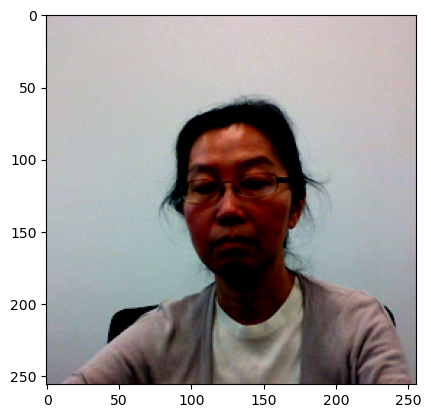

In [10]:
plt.imshow(hr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


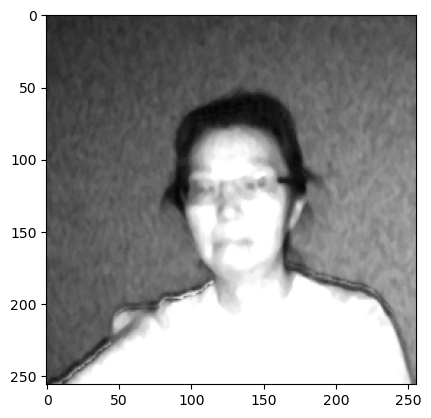

In [11]:
plt.imshow(lr_sample)

In [12]:
# plt.imshow(hiseq_sample)

Text(0.5, 1.0, 'Y distribution of HR-norm imgs')

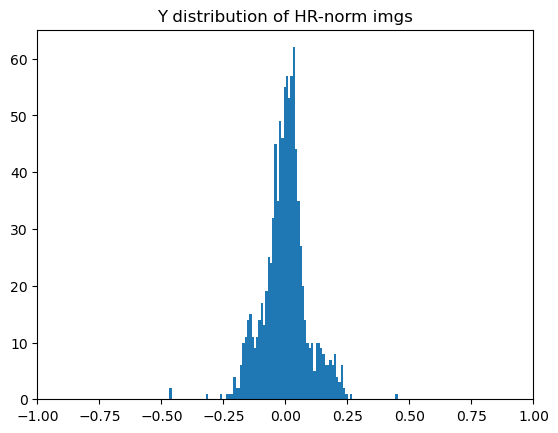

In [13]:
plt.hist(hr_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of HR-norm imgs')

Text(0.5, 1.0, 'Y distribution of LR-norm imgs')

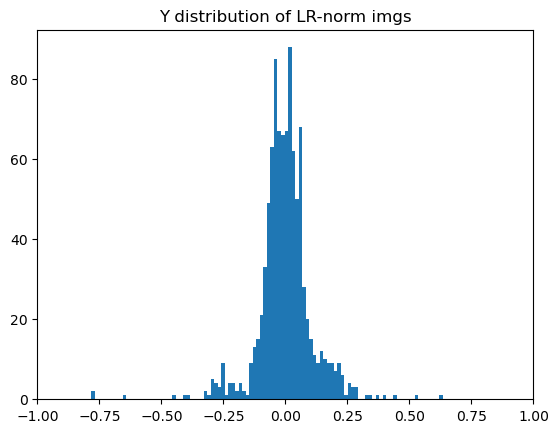

In [14]:
plt.hist(lr_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of LR-norm imgs')

In [15]:
# plt.hist(hiseq_y, bins=100)
# plt.xlim(0, 1)
# plt.title('Y distribution of Hiseq imgs')

Text(0.5, 1.0, 'Raw pixel distribution of HR-norm imgs')

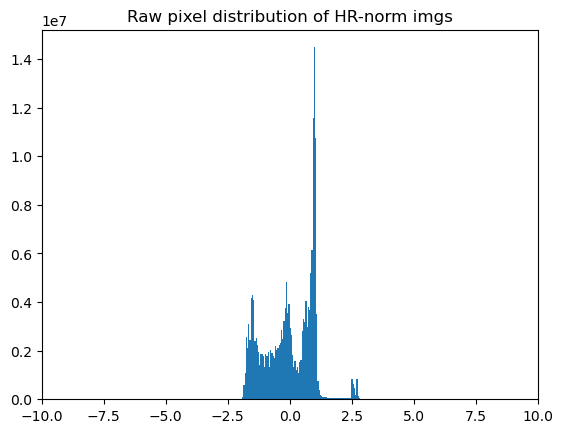

In [16]:
plt.hist(hr_imgs.reshape(-1).numpy(), bins=100)
plt.xlim(-10, 10)
plt.title('Raw pixel distribution of HR-norm imgs')

Text(0.5, 1.0, 'Raw pixel distribution of IR imgs')

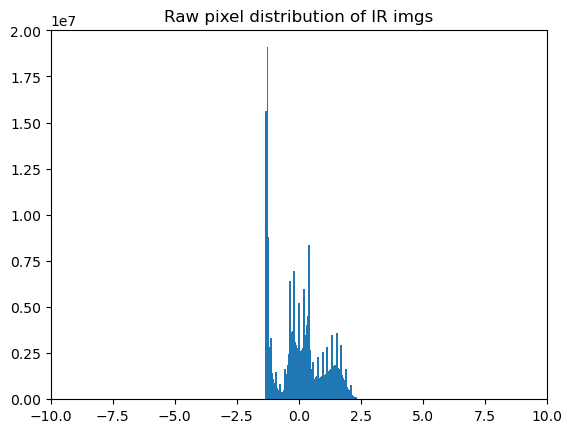

In [17]:
plt.hist(lr_imgs.reshape(-1).numpy(), bins=100)
plt.xlim(-10, 10)
plt.title('Raw pixel distribution of IR imgs')